#**Pytorch Quickstart**

PyTorch has two primitives to work with data: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16736918.50it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 298648.51it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5115833.94it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4990126.41it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To train a model, we need a `loss function` and an `optimizer`.

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303150  [   64/60000]
loss: 2.294661  [ 6464/60000]
loss: 2.283722  [12864/60000]
loss: 2.277525  [19264/60000]
loss: 2.246641  [25664/60000]
loss: 2.228927  [32064/60000]
loss: 2.221776  [38464/60000]
loss: 2.197328  [44864/60000]
loss: 2.198318  [51264/60000]
loss: 2.161812  [57664/60000]
Test Error: 
 Accuracy: 51.5%, Avg loss: 2.160729 

Epoch 2
-------------------------------
loss: 2.170713  [   64/60000]
loss: 2.167874  [ 6464/60000]
loss: 2.114953  [12864/60000]
loss: 2.127749  [19264/60000]
loss: 2.071315  [25664/60000]
loss: 2.011101  [32064/60000]
loss: 2.032079  [38464/60000]
loss: 1.956682  [44864/60000]
loss: 1.972345  [51264/60000]
loss: 1.887979  [57664/60000]
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.895602 

Epoch 3
-------------------------------
loss: 1.928376  [   64/60000]
loss: 1.908153  [ 6464/60000]
loss: 1.792414  [12864/60000]
loss: 1.830286  [19264/60000]
loss: 1.716154  [25664/60000]
loss: 1.658406  [32064/600

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


#**Tensors**

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data.

In [12]:
import torch
import numpy as np

Initializing a Tensor
Tensors can be initialized in various ways. Take a look at the following examples:

- Directly from data: Tensors can be created directly from data. The data type is automatically inferred.

In [13]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

- From a NumPy array: Tensors can be created from NumPy arrays (and vice versa)

In [14]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

- From another tensor: The new tensor retains the properties (shape, datatype) of the argument tensor, unless explicitly overridden.

In [15]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.2089, 0.1697],
        [0.6067, 0.5885]]) 



- With random or constant values: `shape` is a tuple of tensor dimensions. In the functions below, it determines the dimensionality of the output tensor.

In [16]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.3644, 0.0040, 0.0402],
        [0.5517, 0.9148, 0.7080]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


**Attributes of a Tensor**

Tensor attributes describe their shape, datatype, and the device on which they are stored.

In [17]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


**Operations on Tensors**

Over 100 tensor operations, including arithmetic, linear algebra, matrix manipulation (transposing, indexing, slicing). Each of these operations can be run on the GPU (at typically higher speeds than on a CPU). By default, tensors are created on the CPU. We need to explicitly move tensors to the GPU using `.to` method (after checking for GPU availability). Keep in mind that copying large tensors across devices can be expensive in terms of time and memory!

In [18]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

**Standard numpy-like indexing and slicing:**

In [19]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


**Joining tensors:**

You can use torch.cat to concatenate a sequence of tensors along a given dimension.

In [20]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


**Arithmetic Operations**

In [21]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

**Single element tensors:**

If you have a one-element tensor, for example by aggregating all values of a tensor into one value, you can convert it to a Python numerical value using `item()`

In [22]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


**In-place operations:**

Operations that store the result into the operand are called in-place. They are denoted by a `_` suffix. For example: `x.copy_(y)`, `x.t_()`, will change `x`.

In [23]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


**Bridge with NumPy**

Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.

**Tensor to NumPy array:**

In [24]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


A change in the tensor reflects in the NumPy array.

In [25]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


numPy array to Tensor

In [26]:
n = np.ones(5)
t = torch.from_numpy(n)

Changes in the numPy array reflects in the tensor.

In [27]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


#**Datasets and DataLoaders**

PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

**Loading Dataset**

- `root` is the path where the train/test data is stored,
- `train` specifies training or test dataset,
- `download=True` downloads the data from the internet if it’s not available at root.
- `transform` and `target_transform` specify the feature and label transformations

In [28]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

**Iterating and Visualizing Dataset**

We can index Datasets manually like a list: `training_data[index]`

`for i in range(1, cols * rows + 1)`: This is a loop that iterates over a range of numbers from 1 to 9 (since cols * rows + 1 = 9 + 1 = 10). It will execute the body of the loop 9 times, once for each subplot.

    sample_idx = torch.randint(len(training_data), size=(1,)).item()
sample_idx: This line randomly selects an index from the training dataset. `torch.randint(len(training_data), size=(1,))` generates a random integer in the range `[0, len(training_data)-1]`, where `len(training_data)` is the number of samples in the dataset. `.item()` converts the single-element tensor to a Python scalar.

    img, label = training_data[sample_idx]
img, label: The selected image and its label are extracted from `training_data` using the randomly selected index `sample_idx`. `img` is the image data, and `label` is the corresponding label (a number between 0 and 9).

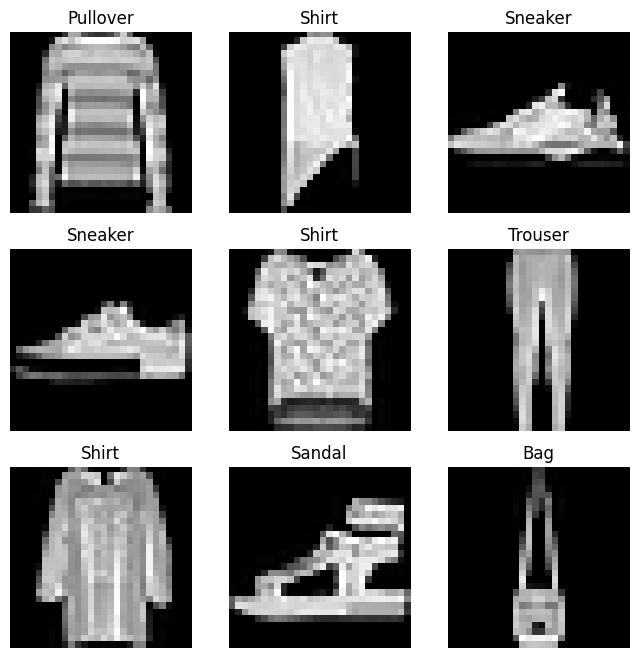

In [29]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Creating custom dataset for our files**

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. In the above example; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

In [30]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

`__init__` : The `__init__` function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms.

`__len__` : The `__len__` function returns the number of samples in our dataset.

`__get_item__` : The `__getitem__` function loads and returns a sample from the dataset at the given index `idx`. Based on the index, it identifies the image’s location on disk, converts that to a tensor using `read_image`, retrieves the corresponding label from the csv data in self.`img_labels`, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

**Preparing your data for training with DataLoaders**

The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval. `DataLoader` is an iterable that abstracts this complexity for us in an easy API.

In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

**Iterate through the DataLoader**

We have loaded that dataset into the `DataLoader` and can iterate through the dataset as needed. Each iteration below returns a batch of `train_features` and `train_labels` (containing `batch_size=64` features and labels respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled .

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


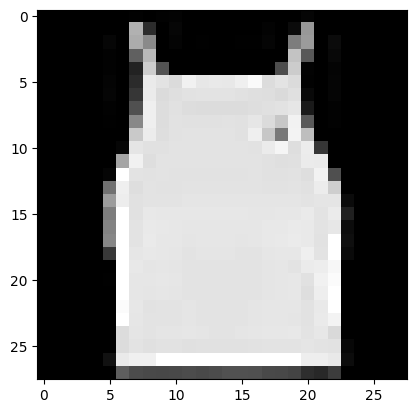

Label: 0


In [32]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#**Transforms**

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters `-transform` to modify the features and `target_transform` to modify the labels - that accept callables containing the transformation logic. The `torchvision.transforms` module offers several commonly-used transforms out of the box.

In this example, the FashionMNIST features are in `PIL` Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use `ToTensor` and `Lambda`.

In [33]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

1. Lambda Function:
- `Lambda(lambda y: ...)`: This is using a Lambda transform to apply a custom function to the target (y) whenever the transform is called. The function is an anonymous lambda function that takes y as input (where y is the target label, typically a number between 0 and 9 for this dataset).

2. Creating one-hot encoders:
- `torch.zeros(10, dtype=torch.float)`: This creates a 1D tensor of length 10 filled with zeros and of data type float. The idea is that this tensor will later be modified to represent the one-hot encoded version of the target label y.

3. scatter_ operation:
- `.scatter_(0, torch.tensor(y), value=1)`: The scatter_ method modifies the original tensor (in-place operation) by placing the value 1 at the index corresponding to the target label y.
- The arguments to scatter_ are as follows:

  `0`: This is the dimension along which the scatter operation will happen (in this case, the 0th dimension, i.e., the tensor's elements).

  `torch.tensor(y)`: This converts the target label y into a tensor. This tensor indicates the index where the 1 should be placed in the tensor.
  
  `value=1`: This is the value that will be placed at the position indicated by y.

**ToTensor()**

ToTensor converts a PIL image or NumPy `ndarray` into a `FloatTensor`. and scales the image’s pixel intensity values in the range [0., 1.]

**Lambda Transforms**

Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls `scatter_` which assigns a `value=1` on the index as given by the label `y`.

In [34]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

#**Build the Neural Network**

Neural networks comprise of layers/modules that perform operations on data. The `torch.nn` namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the `nn.Module`. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In [35]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

**Get device for training**

We want to be able to train our model on a hardware accelerator like the GPU or MPS, if available. We check if `torch.cuda` or `torch.backends.mps` are available, otherwise we use the CPU.

In [36]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


**Define the class**

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the forward method.

In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of NeuralNetwork, and move it to the device, and print its structure.

In [38]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model’s `forward`, along with some background operations. Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the `nn.Softmax` module.

In [39]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4])


**Model Layers**

Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network.

In [40]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


- nn.Flatten

  We initialize the `nn.Flatten` layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

In [41]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


- nn.Linear

  The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

In [42]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


- nn.ReLu

  Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce *nonlinearity*, helping neural networks learn a wide variety of phenomena.

  In this model, we use `nn.ReLU` between our linear layers, but there’s other activations to introduce non-linearity in your model.

In [43]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.0343,  0.1365, -0.2063,  0.0288,  0.3353, -0.1831,  0.3890, -0.2587,
          0.0166, -0.1484,  0.1154, -0.0544,  0.4233,  0.2326, -0.0413, -0.1447,
          0.1310, -0.3075, -0.1368, -0.2292],
        [-0.2788,  0.1598, -0.1512,  0.1671,  0.3597,  0.0377,  0.3063, -0.4839,
         -0.0713, -0.3903,  0.3611, -0.0050, -0.1367, -0.0882, -0.1979, -0.2922,
          0.1926, -0.1085, -0.3518, -0.1201],
        [-0.1043,  0.3687, -0.1112,  0.1650,  0.1901, -0.1021,  0.4300, -0.1767,
          0.0033, -0.1213,  0.2273, -0.3175,  0.0493,  0.0443, -0.4144, -0.2370,
          0.6470, -0.2635, -0.3751, -0.1513]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.1365, 0.0000, 0.0288, 0.3353, 0.0000, 0.3890, 0.0000, 0.0166,
         0.0000, 0.1154, 0.0000, 0.4233, 0.2326, 0.0000, 0.0000, 0.1310, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.1598, 0.0000, 0.1671, 0.3597, 0.0377, 0.3063, 0.0000, 0.0000,
         0.0000, 0.3611, 0.0000, 0.0000, 0.0000, 0.00

- nn.Sequential

  `nn.Sequential` is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network like `seq_modules`.

In [44]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

- nn.Softmax

  The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the nn.Softmax module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1.

In [45]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

**Model Parameters**

Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training. Subclassing nn.Module automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s `parameters()` or `named_parameters()` methods.

In [46]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0111,  0.0309,  0.0236,  ...,  0.0046, -0.0212, -0.0058],
        [ 0.0232,  0.0285,  0.0020,  ..., -0.0295, -0.0348, -0.0237]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0264,  0.0163], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0152,  0.0321,  0.0388,  ...,  0.0070,  0.0362, -0.0052],
        [ 0.0347, -0.0089,  0.0188,  ...,  0.0126, -0.0361, -0.0165]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

#**Automatic Differentiation with torch.autograd()**

When training neural networks, the most frequently used algorithm is **back propagation**. In this algorithm, parameters (model weights) are adjusted according to the **gradient** of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called `torch.autograd`. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input `x`, parameters `w` and `b`, and some loss function.

In [47]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

**Tensors, Functions and Computational Graph**

This code defines the following computational graph:

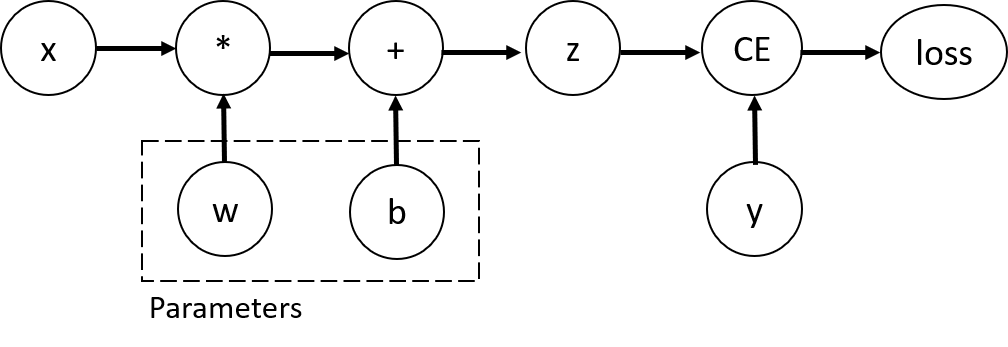

In this network, `w` and `b` are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the `requires_grad` property of those tensors.

You can set the value of `requires_grad` when creating a tensor, or later by using `x.requires_grad_(True)` method.

A function that we apply to tensors to construct computational graph is in fact an object of class `Function`. This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in `grad_fn` property of a tensor.

In [48]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7a7a16df1a50>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7a7a16df1ba0>


**Computing Gradients**

To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need:
$$\frac{\partial loss}{\partial \text{w}}$$
and
$$\frac{\partial loss}{\partial \text{b}}$$
 under some fixed values of `x` and `y`. To compute those derivatives, we call `loss.backward()`, and then retrieve the values from `w.grad` and `b.grad`:

In [49]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0213, 0.0587, 0.0134],
        [0.0213, 0.0587, 0.0134],
        [0.0213, 0.0587, 0.0134],
        [0.0213, 0.0587, 0.0134],
        [0.0213, 0.0587, 0.0134]])
tensor([0.0213, 0.0587, 0.0134])


- Note:

  1. We can only obtain the `grad` properties for the leaf nodes of the computational graph, which have `requires_grad` property set to `True`. For all other nodes in our graph, gradients will not be available.

  2. We can only perform gradient calculations using `backward` once on a given graph, for performance reasons. If we need to do several `backward` calls on the same graph, we need to pass `retain_graph=True` to the `backward` call.

**Disabling Gradient Tracking**

By default, all tensors with `requires_grad=True` are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with `torch.no_grad()` block:

In [50]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the `detach()` method on the tensor:

In [51]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:
- To mark some parameters in your neural network as **frozen parameters**.

- To **speed up computations** when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

**More on omputational Graphs**

Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor

- maintain the operation’s gradient function in the DAG.

The backward pass kicks off when `.backward()` is called on the DAG root. `autograd` then:

- computes the gradients from each `.grad_fn`,

- accumulates them in the respective tensor’s `.grad` attribute

- using the chain rule, propagates all the way to the leaf tensors.

Note:

**DAGs are dynamic in PyTorch** An important thing to note is that the graph is recreated from scratch; after each `.backward()` call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed.

#**Tensor Gradients and Jacobian Products**

In many cases, we have a scalar loss function, and we need to compute the gradient with respect to some parameters. However, there are cases when the output function is an arbitrary tensor. In this case, PyTorch allows you to compute so-called **Jacobian product**, and not the actual gradient.

For a vector function $\vec{y} = f(\vec{x})$, where $\vec{x} = \langle x_1, \dots, x_n \rangle$ and $\vec{y} = \langle y_1, \dots, y_m \rangle$, a gradient of $\vec{y}$ with respect to $\vec{x}$ is given by the Jacobian matrix:

$$
J = \begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & \dots & \frac{\partial y_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial y_m}{\partial x_1} & \dots & \frac{\partial y_m}{\partial x_n}
\end{pmatrix}
$$

Instead of computing the Jacobian matrix itself, PyTorch allows you to compute the **Jacobian Product** $v^T \cdot J$ for a given input vector $v = (v_1, \dots, v_m)$. This is achieved by calling `backward` with $v$ as an argument. The size of $v$ should be the same as the size of the original tensor, with respect to which we want to compute the product:


In [52]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Notice that when we call `backward` for the second time with the same argument, the value of the gradient is different. This happens because when doing `backward` propagation, PyTorch **accumulates the gradients**, i.e. the value of computed gradients is added to the `grad` property of all leaf nodes of computational graph. If you want to compute the proper gradients, you need to zero out the `grad` property before. In real-life training an optimizer helps us to do this.

Previously we were calling `backward()` function without parameters. This is essentially equivalent to calling `backward(torch.tensor(1.0))`, which is a useful way to compute the gradients in case of a scalar-valued function, such as loss during neural network training.

#**Optimizing Model Parameters**

Now that we have a model and data it’s time to train, validate and test our model by optimizing its parameters on our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters (as we saw in the previous section), and **optimizes** these parameters using gradient descent.

In [53]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates.

We define the following hyperparameters for training:
- **Number of Epochs** - the number times to iterate over the dataset

- **Batch Size** - the number of data samples propagated through the network before the parameters are updated

- **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [54]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

**Optimization Loop**

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
- **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.

- **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

**Loss Function**

When presented with some training data, our untrained network is likely not to give the correct answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include `nn.MSELoss` (Mean Square Error) for regression tasks, and `nn.NLLLoss` (Negative Log Likelihood) for classification. `nn.CrossEntropyLoss` combines `nn.LogSoftmax` and `nn.NLLLoss`.

In [55]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

**Optimizer**

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the `optimizer` object. Here, we use the ***SGD*** optimizer; additionally, there are many different optimizers available in PyTorch such as ***ADAM*** and ***RMSProp***, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

In [56]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:

- Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

- Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.

- Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

**Full Implementation**

We define `train_loop` that loops over our optimization code, and `test_loop` that evaluates the model’s performance against our test data.

In [57]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to `train_loop` and `test_loop`.

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310048  [   64/60000]
loss: 2.292969  [ 6464/60000]
loss: 2.267977  [12864/60000]
loss: 2.260323  [19264/60000]
loss: 2.234658  [25664/60000]
loss: 2.208857  [32064/60000]
loss: 2.223103  [38464/60000]
loss: 2.193055  [44864/60000]
loss: 2.184443  [51264/60000]
loss: 2.147329  [57664/60000]
Test Error: 
 Accuracy: 34.5%, Avg loss: 2.142128 

Epoch 2
-------------------------------
loss: 2.156567  [   64/60000]
loss: 2.143061  [ 6464/60000]
loss: 2.076713  [12864/60000]
loss: 2.100637  [19264/60000]
loss: 2.031149  [25664/60000]
loss: 1.975702  [32064/60000]
loss: 2.009558  [38464/60000]
loss: 1.933573  [44864/60000]
loss: 1.933731  [51264/60000]
loss: 1.863648  [57664/60000]
Test Error: 
 Accuracy: 55.0%, Avg loss: 1.855431 

Epoch 3
-------------------------------
loss: 1.886781  [   64/60000]
loss: 1.854490  [ 6464/60000]
loss: 1.728540  [12864/60000]
loss: 1.789006  [19264/60000]
loss: 1.661328  [25664/60000]
loss: 1.618383  [32064/600

#**Save and Load the Model**

PyTorch models store the learned parameters in an internal state dictionary, called `state_dict`. These can be persisted via the `torch.save` method:

In [59]:
import torch
import torchvision.models as models

In [60]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 79.0MB/s]


To load model weights, you need to create an instance of the same model first, and then load the parameters using `load_state_dict()` method.

In [61]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Note:

be sure to call `model.eval()` method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

**Saving and Loading model with shapes**

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass model (and not `model.state_dict()`) to the saving function:

In [62]:
torch.save(model, 'model.pth')

We can then load the model like this:

In [63]:
model = torch.load('model.pth')

This approach uses Python pickle module when serializing the model, thus it relies on the actual class definition to be available when loading the model.